# A Guide to Time Series Analysis in Python

<a href="https://builtin.com/data-science/time-series-python">Link to the blog</a>

Air passenger time series data

In [1]:
import pandas as pd
df = pd.read_csv("AirPassengers.csv")

In [2]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.shape # 144 data rows are there

(144, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


Data is recorded from 1949 to 1960 for every month

In [8]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


Note that this process automatically inserts the first day of each month, which is basically a dummy value since we have no daily passenger data.

The next thing we can do is convert the month column to an index. This will allow us to more easily work with some of the packages we will be covering later:

In [9]:
df.index = df['Month']

In [10]:
df.head()

,Month,#Passengers
Month,,
1949-01-01,1949-01-01,112
1949-02-01,1949-02-01,118
1949-03-01,1949-03-01,132
1949-04-01,1949-04-01,129
1949-05-01,1949-05-01,121


In [11]:
df = df.drop(columns=['Month'], axis = 1)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='Month'>

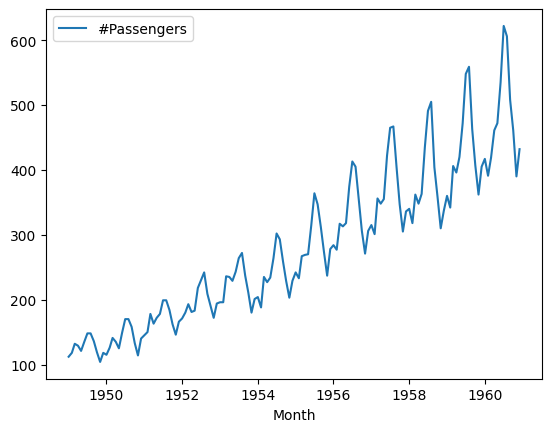

In [13]:
sns.lineplot(df)

# Visual test of stationarty using MA (Moving Average)

In [14]:
rolling_mean = df.rolling(7).mean()
rolling_std = df.rolling(7).std()

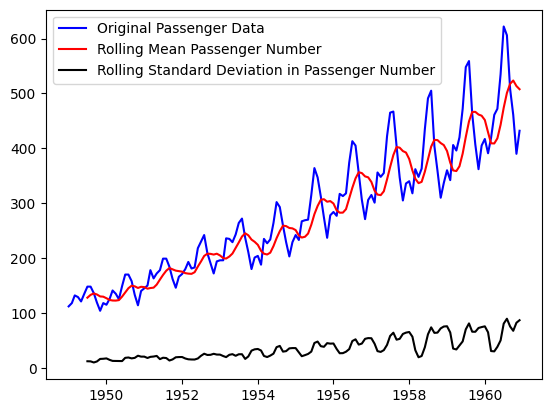

In [21]:
plt.plot(df, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean Passenger Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.legend(loc="best")

# Augmented Dickey Fuller test for stationarity

In [22]:
from statsmodels.tsa.stattools import adfuller

Next, let’s pass our data frame into the adfuller method. Here, we specify the autolag parameter as “AIC,” which means that the lag is chosen to minimize the information criterion:

In [23]:
adft = adfuller(df, autolag='AIC')

In [25]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0    0.815369              Test Statistics
1    0.991880                      p-value
2   13.000000             No. of lags used
3  130.000000  Number of observations used
4   -3.481682          critical value (1%)
5   -2.884042          critical value (5%)
6   -2.578770         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than five percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the number of passengers.

# Autocorrelation

Checking time series data for autocorrelation in Python is another important part of the analytic process. This is a measure of how correlated time series data is at a given point in time with past values, which has huge implications across many industries. For example, if our passenger data has strong autocorrelation, we can assume that high passenger numbers today suggest a strong likelihood that they will be high tomorrow as well.

In [27]:
ac_lag1 = df['#Passengers'].autocorr(lag=1)
ac_lag1

0.9601946480498522

In [29]:
autocorrelation_lag3 = df['#Passengers'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df['#Passengers'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df['#Passengers'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

Three Month Lag:  0.837394765081794
Six Month Lag:  0.7839187959206183
Nine Month Lag:  0.8278519011167602


We see that, even with a nine-month lag, the data is highly autocorrelated. This is further illustration of the short- and long-term trends in the data.

# Decomposition

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

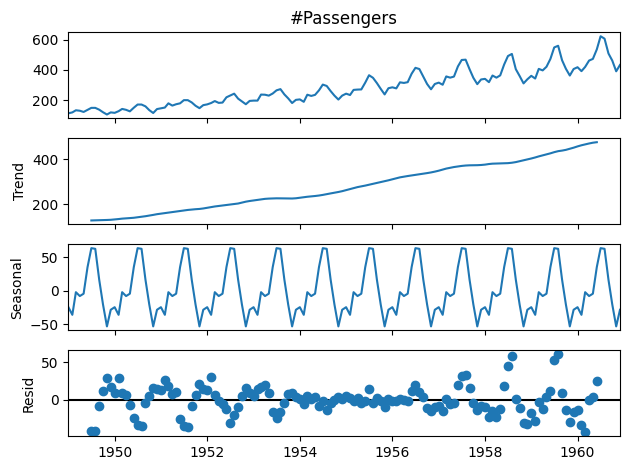

In [34]:
decompose = seasonal_decompose(df["#Passengers"], model='additive', period=12)
decompose.plot()
plt.show()

# Forecasting

Time series forecasting allows us to predict future values in a time series given current and past data. Here, we will use the ARIMA method to forecast the number of passengers, which allows us to forecast future values in terms of a linear combination of past values. We will use the auto_arima package, which will allow us to forgo the time consuming process of hyperparameter tuning.

In [35]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


First, let’s split our data for training and testing and visualize the split:

In [36]:
df["Date"] = df.index
train = df[df['Date']<pd.to_datetime("1960-08", format="%Y-%m")]

In [38]:
train = train.drop(columns=["Date"])
train.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [39]:
df["Date"] = df.index
test = df[df['Date']>=pd.to_datetime("1960-08", format="%Y-%m")]

In [40]:
test = test.drop(columns=["Date"])
test.head()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


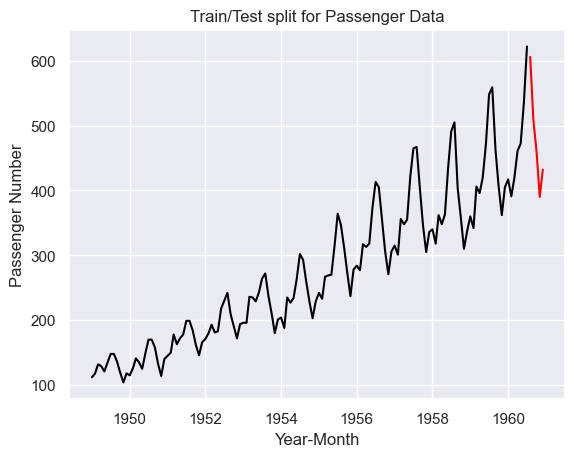

In [45]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
plt.show()

In [42]:
from pmdarima.arima import auto_arima

In [48]:
model = auto_arima(train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True).fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=987.281, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=977.189, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=978.152, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=976.617, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=977.559, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=978.445, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=978.236, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=977.454, Time=0.04 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=980.179, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=978.147, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.185 seconds


In [49]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast, index = test.index, columns=['Prediction'])

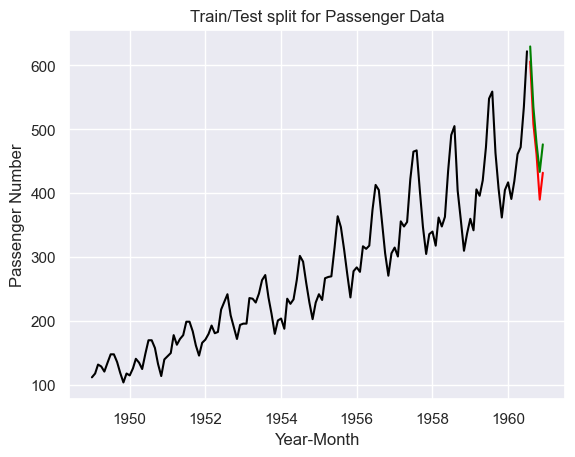

In [50]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = 'green')
plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')
plt.show()

In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  32.93662006480367
